<a href="https://colab.research.google.com/github/mugalan/classical-mechanics-from-a-geometric-point-of-view/blob/main/rigid-body-control/Twin_Rotor_Attitude_Tracking_DHSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initialization

In [1]:
import numpy as np
import scipy as sp
from scipy.integrate import odeint
import math
from numpy import linalg
import sympy
from sympy import symbols
from sympy import *

import plotly.graph_objects as go
import plotly.express as px
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from IPython.display import display, Math, Latex

In [ ]:
class mugas_rigid_body_functions:

  def __init__(self):
    self=[];

  def simulateDySystem(self, dynamicSystemModel, Tmax, dT, X0, sysPara, figTitle, xLabel, yLabel):
    t = np.linspace(0, Tmax, int(Tmax/dT+1))
    sol = odeint(dynamicSystemModel, X0, t, args=(sysPara,));
    self.soln=sol;
    fig = go.Figure()
    [nt,nS]=sol.shape;

    # Add traces
    for nn in range(nS):
      fig.add_trace(go.Scatter(x=t, y=sol[:,nn], mode='lines+markers', name='x'+str(nn+1)))
      fig.update_layout(title=figTitle, xaxis=dict(title=xLabel),yaxis=dict(title=yLabel))

    fig.show()
    return [t,sol,fig]

  def hatMatrix(self, X):
    return np.array([[0., -X[2], X[1]],[X[2], 0., -X[0]],[-X[1], X[0], 0.]])

  def qFromAxisAngles(self, theta, unitAxis):
    return np.concatenate(([np.cos(theta/2)],np.sin(theta/2)*np.array(unitAxis)))

  def RfromQuaternions(self,q):
    q0=q[0]; w=q[1:];
    R=np.identity(3)+2*q0*self.hatMatrix(w)+2*self.hatMatrix(w) @ self.hatMatrix(w);
    return R

  def rotationMatrix2EulerAngles(self,R):
    if R[2,2] <1:
      if R[2,2] > -1:
        theta2=math.acos(R[2,2]);
        theta1=math.atan2(R[0,2],R[1,2]);
        theta3=math.atan2(R[2,0],-R[2,1]);
      else: #R[2,2]=-1 No Unique solution
        theta2=np.pi;
        theta1=-math.atan2(R[0,1],-R[0,0]);
        theta3=0;
    else: # R[2,2] = +1 No Unique solution
      theta2 = 0;
      theta1 = math.atan2(R[0,1],R[0,0]) ;
      theta3 = 0;
    return [np.pi-theta1,theta2,np.pi-theta3]


  def rotate_and_translate(self,objectVertices,R,b):
    #object vertices should be given as an numpy array of shape (3,n)
    #Ex - X=[0, 0, 2, 2, 0, 0, 2, 2], Y=[0, 2, 2, 0, 0, 2, 2, 0], Z=[0, 0, 0, 0, 1, 1, 1, 1]; objectVertices=[X,Y,Z]
    return np.array([[b[0],b[1],b[2]]]).T + R @ objectVertices


  def addOrthNormFrame(self, fig, o, R, axisRange, axisColor):
    e1=[1,0,0]; e2=[0,1,0]; e3=[0,0,1];
    b1=R @ e1; b2=R @ e2; b3=R @ e3;
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b1[0])], y=[str(o[1]),str(o[1]+b1[1])], z=[str(o[2]),str(o[2]+b1[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b2[0])], y=[str(o[1]),str(o[1]+b2[1])], z=[str(o[2]),str(o[2]+b2[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b3[0])], y=[str(o[1]),str(o[1]+b3[1])], z=[str(o[2]),str(o[2]+b3[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.update_layout(showlegend=False, scene=dict(xaxis=dict(range=axisRange[0], autorange=False), yaxis=dict(range=axisRange[1], autorange=False), zaxis=dict(range=axisRange[2], autorange=False), aspectratio=dict(x=1, y=1, z=1)))
    return fig

  def cube_vertices(self,cubeDimensions):
    l=cubeDimensions['l']; w=cubeDimensions['w']; h=cubeDimensions['h'];
    xp=cubeDimensions['xp']; yp=cubeDimensions['yp']; zp=cubeDimensions['zp'];
    #X=[0, 0, l, l, 0, 0, l, l]; Y=[0, w, w, 0, 0, w, w, 0]; Z=[0, 0, 0, 0, h, h, h, h]; XX=[X,Y,Z];
    X=[-xp, -xp, l-xp, l-xp, -xp, -xp, l-xp, l-xp]; Y=[-yp, w-yp, w-yp, -yp, -yp, w-yp, w-yp, -yp]; Z=[-zp, -zp, -zp, -zp, h-zp, h-zp, h-zp, h-zp]; XX=[X,Y,Z];
    #X=[-l, -l, l, l, -l, -l, l, l]; Y=[-w, w, w, -w, -w, w, w, -w]; Z=[-h, -h, -h, -h, h, h, h, h]; XX=[X,Y,Z];
    return XX


  def animate_particle_motion(self, XX, axisRange, figTitle):
    xx=[jj[0] for jj in XX]
    yy=[jj[1] for jj in XX]
    zz=[jj[2] for jj in XX]

    fig = go.Figure(
        data=[go.Scatter3d(x=[xx[0]], y=[yy[0]],z=[zz[0]],
                        mode="markers",
                        marker=dict(color="red", size=10)),
              go.Scatter3d(x=xx, y=yy,z=zz, name='Path',
                        mode="lines",
                        line=dict(color="blue", width=2))],
        layout=go.Layout(
            scene = dict(
                        xaxis=dict(range=axisRange[0], autorange=False),
                        yaxis=dict(range=axisRange[1], autorange=False),
                        zaxis=dict(range=axisRange[2], autorange=False),
                        aspectratio=dict(x=1, y=1, z=1),
            ),
            title_text=figTitle, hovermode="closest",
            updatemenus=[dict(type="buttons",
                              buttons=[dict(label="Play",
                                            method="animate",
                                            args=[None])])]),
        frames=[go.Frame(
            data=[go.Scatter3d(
                x=[p[0]],
                y=[p[1]],
                z=[p[2]],
                name='Particle',
                mode="markers",
                marker=dict(color="red", size=10))])

            for p in XX]
    )

    fig.show()
    return fig

  def animated_cube_flat_shading(self, cubeVertices, figTitle):
    fig = go.Figure(
        frames=[go.Frame(data=[
          go.Mesh3d(
            # 8 vertices of a cube
            x=xx[0][0],
            y=xx[0][1],
            z=xx[0][2],
            # i, j and k give the vertices of triangles
            i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
            j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
            k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
            name='y',
            opacity=0.6,
            color='#DC143C',
            flatshading = True)]) for xx in cubeVertices])

    fig.add_trace(go.Mesh3d(
            # 8 vertices of a cube
            x=cubeVertices[0][0][0],
            y=cubeVertices[0][0][1],
            z=cubeVertices[0][0][2],
            # i, j and k give the vertices of triangles
            i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
            j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
            k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
            name='y',
            opacity=0.6,
            color='#DC143C',
            flatshading = True)
        )
    duration=10;
    fig.update_layout(
          title=figTitle,
          width=600,
          height=600,
          scene=dict(
                      xaxis=dict(range=[-5., 5.], autorange=False),
                      yaxis=dict(range=[-5., 5.], autorange=False),
                      zaxis=dict(range=[-5., 5.], autorange=False),
                      aspectratio=dict(x=1, y=1, z=1),
                      ),
          updatemenus=[dict(type="buttons",
                              buttons=[dict(label="Play",
                                            method="animate",
                                            args=[None, {"frame": {"duration": duration},"mode": "immediate","fromcurrent": True, "transition": {"duration": duration, "easing": "linear"},}]
                                            )])])
    len(fig.frames)
    fig.show()
    return fig


  def simulating_a_cube(self, dt, Tmax, cubeDimensions, parameters,ICs):
    XX=self.cube_vertices(cubeDimensions);

    #Xs=self.eulers_method(dt,Tmax,parameters,ICs);
    Xs=self.runga_kutta_method(dt,Tmax,parameters,ICs);

    ICR=ICs[0][0];
    XX0=ICR @ XX;

    rotatedVertices=[[XX0]]
    for X in Xs:
      #print(X[0])
      R=X[0][0];
      o=X[0][1];
      XXi=self.rotate_and_translate(XX,R,o);
      XX0=XXi;
      rotatedVertices+=[[XX0]];
    return rotatedVertices


  def eulers_method(self, dt,Tmax,parameters,ICs):
    M=parameters['M']; II=parameters['II'];
    invII=linalg.inv(II) ;
    timeSteps=np.arange(0,Tmax+dt,dt);
    R=ICs[0][0]; o=ICs[0][1];
    omega=ICs[1]; doto=ICs[2]; Xc=ICs[3];
    X=ICs;
    spi=R@II@R.T@omega; p=M*doto;
    Xout=[X];
    for t in timeSteps:
      [taue,fe]=externalForceModel(self, parameters,X);
      [taua,fa]=actuator(self, parameters, t, X,taue,fe);

      dspi=taue+taua;
      dp=fe+fa;
      dXc=controller_dynamics(self, t,X,taue,fe,parameters)

      if linalg.norm(omega)>=0.0001:
        nomega=omega/linalg.norm(omega);
        thetaomegat=dt*linalg.norm(omega);
      else:
        nomega=np.array([0,0,0]);
        thetaomegat=0;
      qomegat=np.concatenate(([np.cos(thetaomegat/2)],np.sin(thetaomegat/2)*nomega));
      R=self.RfromQuaternions(qomegat) @ R;
      o=o+dt*doto;
      spi=spi+dt*dspi;
      p=p+dt*dp;
      doto=p/M;
      omega=R @ invII @ R.T @ spi;
      Xc=Xc+dt*dXc;
      X=[[R,o],omega,doto, Xc];
      Xout+=[X]

    return Xout

  def runga_kutta_method(self, dt,Tmax,parameters,ICs):
    M=parameters['M']; II=parameters['II'];
    invII=linalg.inv(II) ;
    timeSteps=np.arange(0,Tmax+dt,dt);
    X=ICs;
    Xout=[X];
    for t in timeSteps:
      Y1=self.rk4_function(0.5*dt, X, t, X, parameters);
      Y2=self.rk4_function(0.5*dt, X, t+0.5*dt, Y1, parameters);
      Y3=self.rk4_function(dt, X, t+0.5*dt, Y2, parameters);

      [thetaomega1,nomega1,doto1,dp1,dspi1,dXc1]=self.rigid_body_system(parameters, t, X);
      [thetaomega2,nomega2,doto2,dp2,dspi2,dXc2]=self.rigid_body_system(parameters, t+0.5*dt, Y1);
      [thetaomega3,nomega3,doto3,dp3,dspi3,dXc3]=self.rigid_body_system(parameters, t+0.5*dt, Y2);
      [thetaomega4,nomega4,doto4,dp4,dspi4,dXc4]=self.rigid_body_system(parameters, t+dt, Y3);

      omegak=(dt/6.0)*(thetaomega1*nomega1+2*thetaomega2*nomega2+2*thetaomega3*nomega3+thetaomega4*nomega4)
      if linalg.norm(omegak)>=0.0001:
        nomegak=omegak/linalg.norm(omegak);
        thetaomegak=linalg.norm(omegak);
      else:
        nomegak=np.array([0,0,0]);
        thetaomegak=0;
      qomegak=np.concatenate(([np.cos(thetaomegak/2)],np.sin(thetaomegak/2)*nomegak));
      Rk=self.RfromQuaternions(qomegak) @ X[0][0];

      dotok=(1./6.0)*(doto1+2*doto2+2*doto3+doto4);
      dpk=(1./6.0)*(dp1+2*dp2+2*dp3+dp4);
      dspik=(1./6.0)*(dspi1+2*dspi2+2*dspi3+dspi4);
      dXck=(1./6.0)*(dXc1+2*dXc2+2*dXc3+dXc4);

      ok=X[0][1]+dt*dotok;
      pk=X[2]+dt*dpk;
      spik=X[0][0]@II@X[0][0].T@X[1]+dt*dspik;
      Xck=X[3]+dt*dXck;
      omegak=Rk @ linalg.inv(II) @ Rk.T @ spik;
      X=[[Rk,ok],omegak,pk,Xck];
      Xout+=[X]
    return Xout

  def rk4_function(self, dtk, X, tk, Xk, parameters):
    M=parameters['M']; II=parameters['II'];
    [thetaomega1,nomega1,doto1,dp1,dspi1,dXc1]=self.rigid_body_system(parameters, tk, Xk)
    qomega1=np.concatenate(([np.cos(dtk*thetaomega1/2)],np.sin(dtk*thetaomega1/2)*nomega1));
    R1=self.RfromQuaternions(qomega1)@X[0][0];
    p1=X[2]+dtk*dp1;
    spi1=X[0][0]@II@X[0][0].T@X[1]+dtk*dspi1; omega1=R1@linalg.inv(parameters['II'])@R1.T@spi1;
    X1=[[R1, X[0][1]+dtk*doto1],omega1,p1, X[3]+dtk*dXc1]
    return X1

  def rigid_body_system(self, parameters, t, X):
    barX=parameters['CM']; M=parameters['M'];
    R=X[0][0]; omega=X[1]; p=X[2];

    [taue,fe]=externalForceModel(self, parameters,X);
    [taua,fa]=actuator(self, parameters, t, X,taue,fe);

    doto=p/M;
    dp=fe+fa;
    dspi=taue+taua;
    dXc=controller_dynamics(self, t,X,taue,fe,parameters);
    if linalg.norm(omega)>=0.0001:
      nomega=omega/linalg.norm(omega);
      thetaomega=linalg.norm(omega);
    else:
      nomega=np.array([0,0,0]);
      thetaomega=0;
    return [thetaomega,nomega,doto,dp,dspi,dXc]

#Twin Rotor Model

In [12]:
alpha, theta, phi, gamma, R, Omega, I = dynamicsymbols("alpha, theta, phi,gamma, R, Omega, I")
init_vprinting
t, I_1, I_2, I_3, l= symbols('t, I_1, I_2, I_3, l')
init_vprinting()

In [3]:
dtheta = theta.diff(t);ddtheta = dtheta.diff(t)
dalpha = alpha.diff(t);ddalpha = dalpha.diff(t)
dgamma = gamma.diff(t);ddamma = dgamma.diff(t)
dphi = phi.diff(t);ddphi = dphi.diff(t)


R1_phi = Matrix([[1, 0, 0],[0, cos(phi), -sin(phi)],[0, sin(phi),cos(phi)]])
R3_alpha = Matrix([[cos(alpha),-sin(alpha),0],[sin(alpha),cos(alpha),0],[0,0,1]])
R1_gamma = Matrix([[1, 0, 0],[0, cos(gamma), -sin(gamma)],[0, sin(gamma),cos(gamma)]])
R3_theta = Matrix([[cos(theta),-sin(theta),0],[sin(theta),cos(theta),0],[0,0,1]])

In [ ]:
R1_phi

In [10]:
II = Matrix([[I_1, 0, 0],[0, I_2, 0],[0,0,I_3]])

In [11]:
II

⎡II₁   0    0 ⎤
⎢             ⎥
⎢ 0   II₂   0 ⎥
⎢             ⎥
⎣ 0    0   II₃⎦

Image Credits: Bhashitha Maduranga Nawaratne bhashitha614@gmail.com

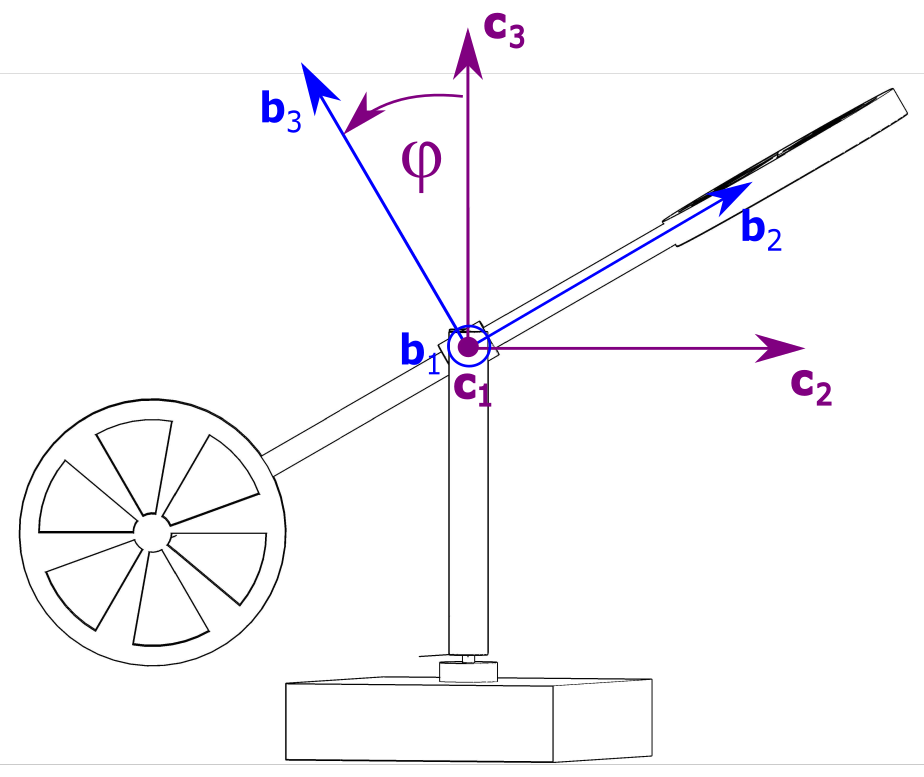

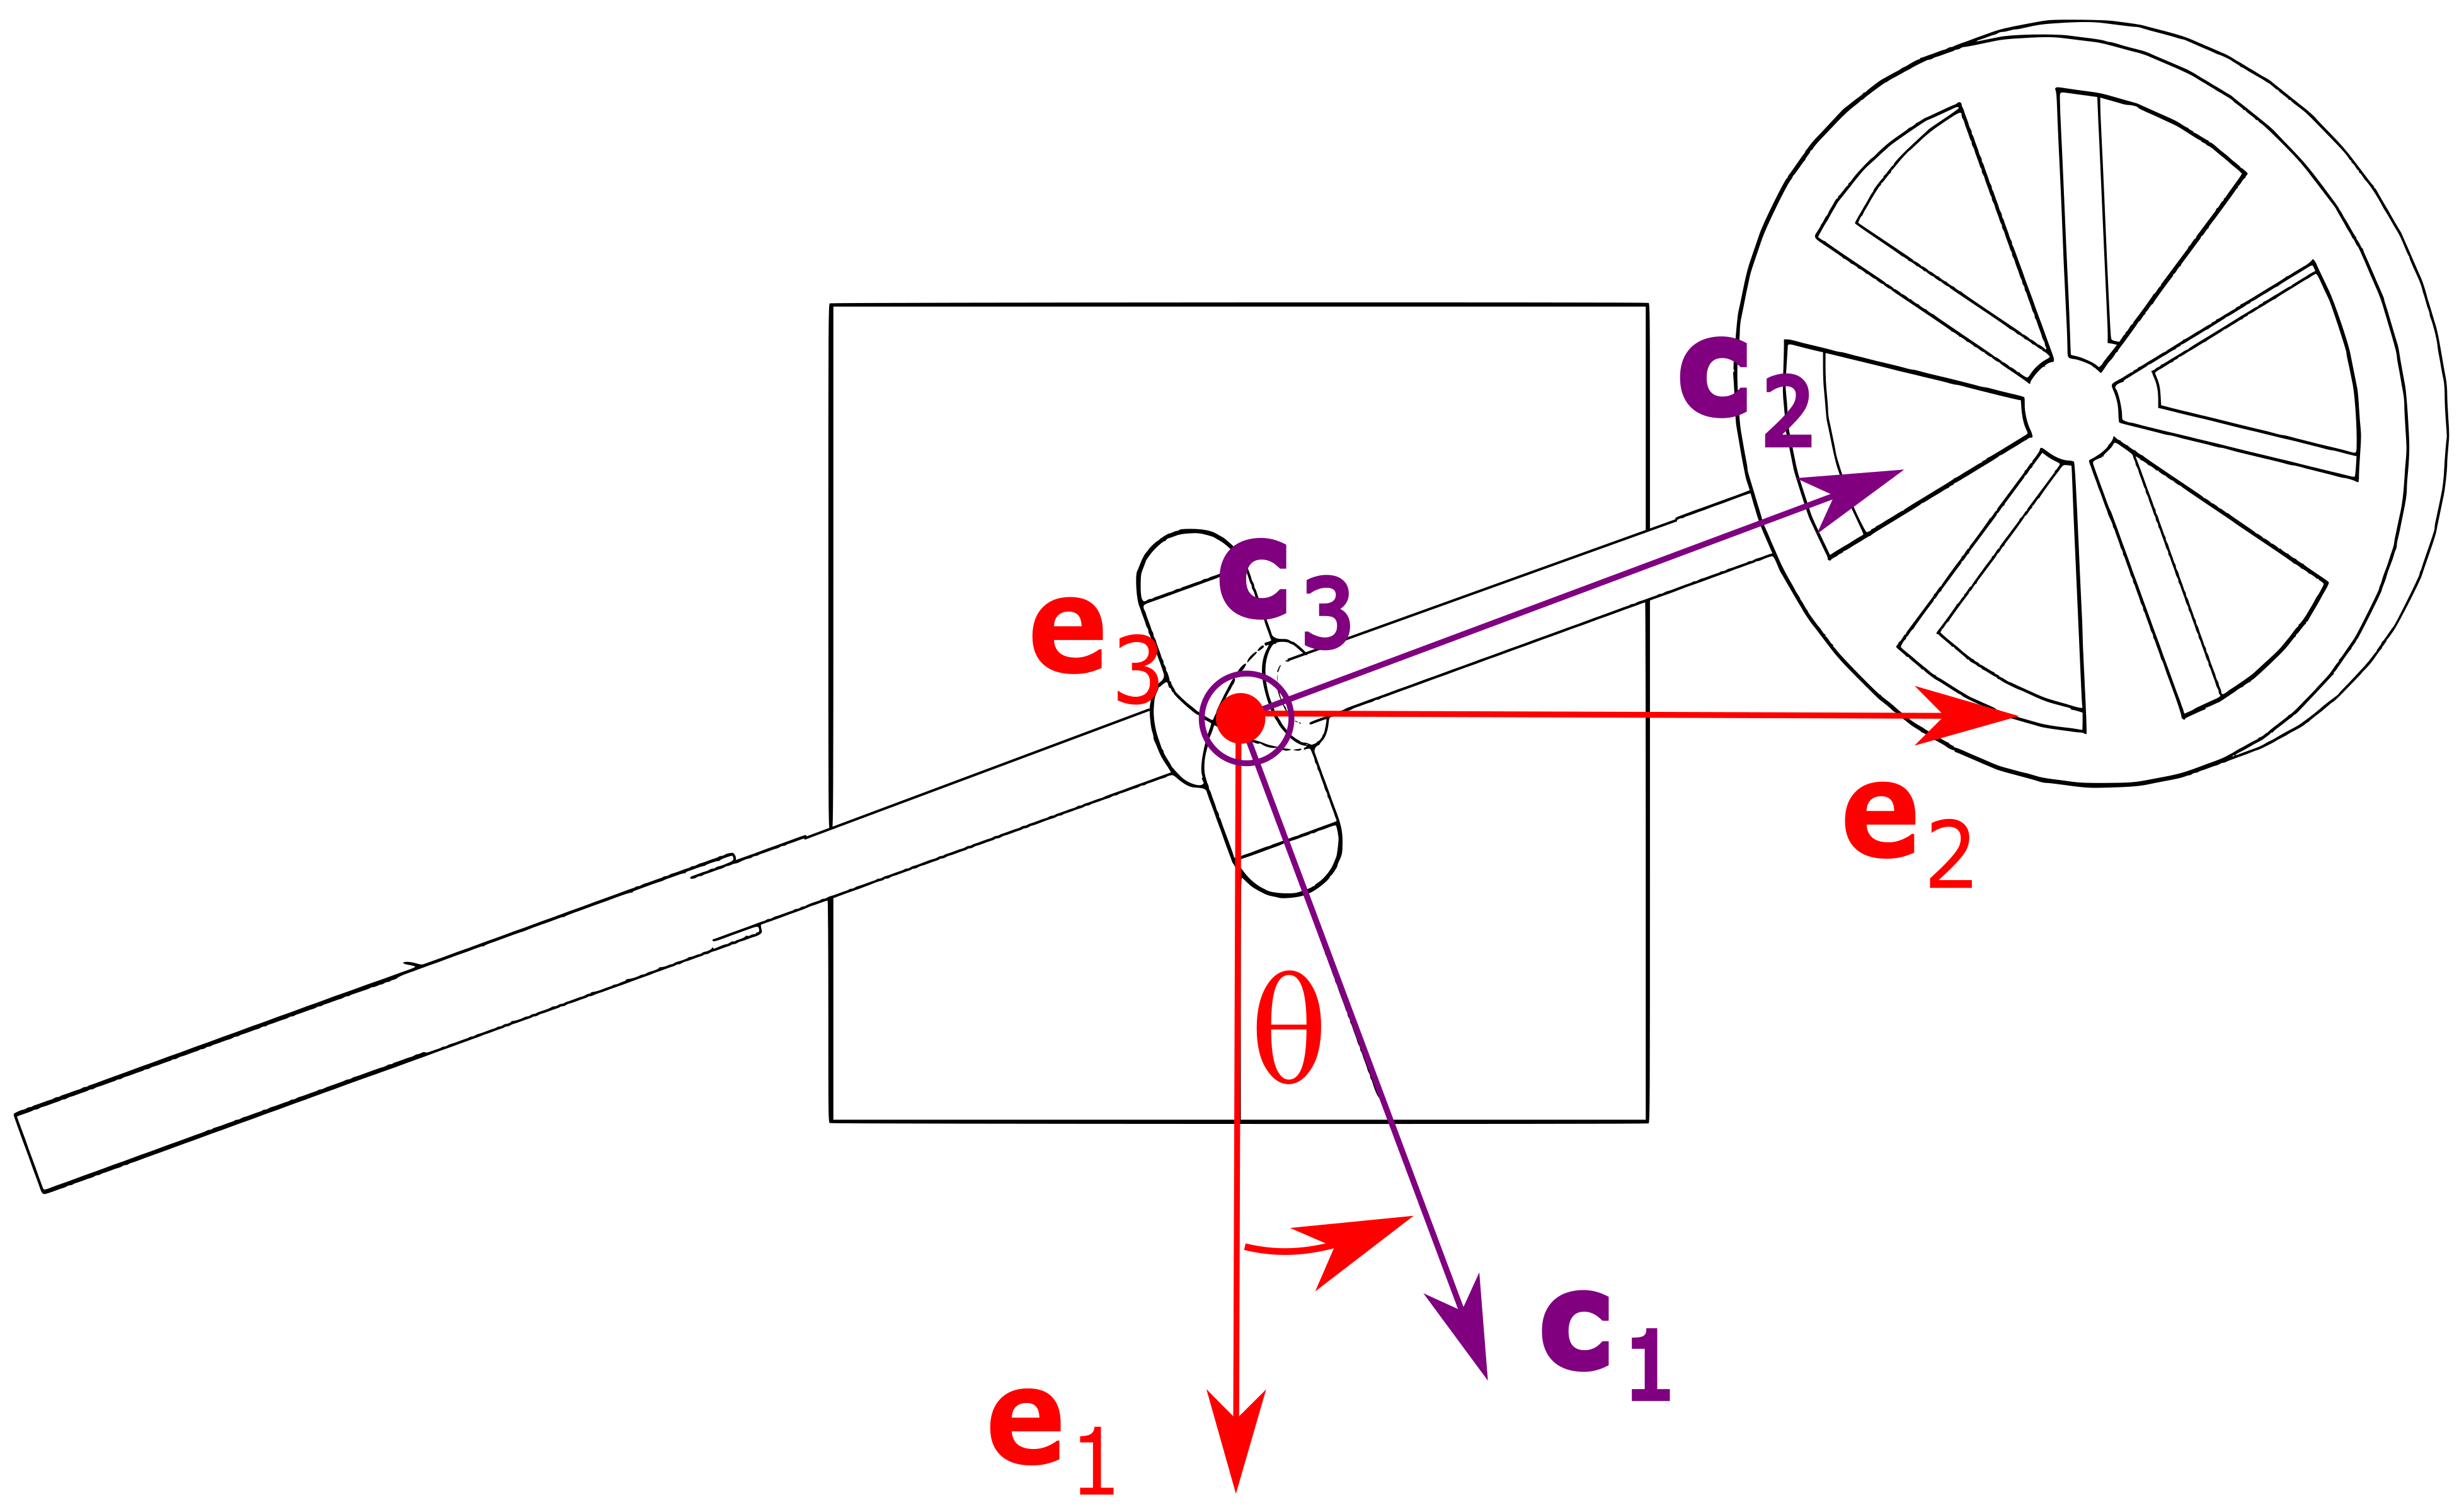

# The Configuration

Let us take inertial frame as $\mathbf{e}$, which is fixed to body part E. And $\mathbf{O}$ as the original of the $\mathbf{e}$-frame. Let $\mathbf{c}$ be another orthongonal frame such that it moves with respect to $\mathbf{e}$ in such a way that $\mathbf{c}_3\equiv \mathbf{e}_3$ and $\mathbf{c}$-frame is always fixed to body part c. Therefore

\begin{align*}
\mathbf{c}=\mathbf{e}\,R_3(\theta)
\end{align*}

\begin{align*}
R_3(\theta)=\begin{bmatrix}
\cos{\theta}&-\sin{\theta}&0\\
\sin{\theta}&\cos{\theta}&0\\
0&0&1
\end{bmatrix}.
\end{align*}

Let $\mathbf{b}$ be another orthonomal frame such that it moves with respect to $\mathbf{c}$ in such a way that $\mathbf{b}_1\equiv \mathbf{c}_1$ and $\mathbf{b}$ is always fixed to body part $\mathbf{B}$.

\begin{align*}
\mathbf{b}=\mathbf{c}\,R_1(\phi)
\end{align*}

\begin{align*}
R_1(\phi)=\begin{bmatrix}
1&0&0\\
0&\cos{\phi}&-\sin{\phi}\\
0&\sin{\phi}&\cos{\phi}
\end{bmatrix}.
\end{align*}

Origin of $\mathbf{e}$-frame and $\mathbf{c}$-frame coincide with each other. Let's take B as the origin of $\mathbf{b}$-frame.

\begin{align*}
\mathbf{b}=\mathbf{c}R_3(\theta)=\mathbf{e}R_1(\phi)R_3(\theta)=\mathbf{e}R
\end{align*}

Which gives

\begin{align*}
R=R_1(\phi)R_3(\theta)
\end{align*}

\begin{align*}
\dot{R}=\dot{R}_1R_3+R_1\dot{R}_3=R_1\widehat{\Omega}_1R_3+R_1{R}_3\widehat{\Omega}_3=R\widehat{\Omega}
\end{align*}

\begin{align*}
\widehat{\Omega}=R_3^T\widehat{\Omega}_1R_3+\widehat{\Omega}_3
\end{align*}

which gives
\begin{align*}
\Omega=R_3^T(\theta)\Omega_1+{\Omega}_3
\end{align*}


# The actuation moments

\begin{align*}
\mathbf{e}\tau=\mathbf{b}\tau_b=\mathbf{b}\begin{bmatrix}
u_1\cos{\alpha}-u_2\cos{\beta}\\
0\\
u_1\sin{\alpha}-u_2\sin{\beta}
\end{bmatrix}
\end{align*}

# Equations of motion

\begin{align*}
\dot{R}=\widehat{\omega}R\\
\pi=R\mathbb{I}R^T\omega\\
\dot{\pi}=RT_b=\tau_u+\tau_e
\end{align*}

In [ ]:
R

#Trajectory Tracking

In this section we investigate the problem of ensuring asymptotic tracking of a sufficiently smooth trajectory $R_r(t)$ in $\mathbb{R}^3\times SO(3)$.

##Configuration error

We notice that the configuration space $SO(3)$ is a group. It is closed under the multiplication operation defined as follows.

Now one can define the configuration error between a system configuration $R\in \mathbb{R}^3\times SO(3)$ and a reference configuration $R_r\in \mathbb{R}^3\times SO(3)$ in a global sense as  
\begin{align}
R_e\triangleq R^{-1}R_r\in  SO(3),
\end{align}
or alternatively as
\begin{align}
R_e\triangleq R_rR^{-1}\in SO(3),
\end{align}

The former is defined as the *left-invariant* error while the latter is defined as the *right-invariant* error.

Notice that both these errors are in the configuration space $SO(3)$ and not in the spatial momentum space of $SO(3)$.

##Tracking error dynamics

Let $R_r(t)$ be a desired trajectory and $\omega_r(t)$ be such that $\widehat{\omega}_r(t)=\dot{R}_rR_r^T$. In line with the system define the reference spatial angular momentum $\pi_r\triangleq R_r\mathbb{I}R_r^T\omega_r$

Define the configurarion error
\begin{align}
R_e&=R_rR^T.
\end{align}
Then the spatial angular velcity of the tracking error is defined by
\begin{align}
\widehat{\omega}_e&\triangleq \dot{R}_eR_e^T=\widehat{\omega}_r(t)-R_e\widehat{\omega}(t)R_e^T
\end{align}
and hence that
\begin{align}
\omega_e&=\omega_r-R_e\omega.
\end{align}
Define the angular momentum error as
\begin{align}
\pi_e\triangleq R\mathbb{I}R_r^T\omega_e=R\mathbb{I}R_r^T(\omega_r-R_e\omega)=R\mathbb{I}R_r^T\omega_r-R\mathbb{I}R^T\omega=R_e^T\pi_r-\pi.
\end{align}


Differentiating $\pi_e$ we have
\begin{align}
\dot{\pi}_e&=R_e^T(\dot{\pi}_r-\omega_e\times \pi_r)-\dot{\pi}=R_e^T(R_r\dot{\Pi}_r+(\omega_r-\omega_e)\times \pi_r)-\dot{\pi}=(R\dot{\Pi}_r+\omega\times \pi_r)-\dot{\pi}
\end{align}



Thus we have the error dynamics
\begin{align}
\dot{R}_e&=\widehat{\omega}_eR_e,\\
\dot{\pi}_e&=(R\dot{\Pi}_r+\omega\times \pi_r)-\tau_u-\tau_e
\end{align}

## Feedforward plus PID control

\begin{align}
\dot{e}_{I_R}&=e_R,\\
\tau_u&=-
\tau_e+(R\dot{\Pi}_r+\omega\times \pi_r)+k_{P_R}e_R+k_{D_R}\pi_e+k_{I_R}e_{I_R}
\end{align}

### The proportional term

Let
\begin{align}
K&=\mathrm{diag}\{\mathbb{K}_1,\mathbb{K}_2,\mathbb{K}_3\}.
\end{align}

for some three distinct constants $\mathbb{K}_1,\mathbb{K}_2,\mathbb{K}_3$.

Then $e_R$ is given by
\begin{align}
\widehat{e}_R&=\frac{1}{2}\left(R_eK-KR_e^T\right).
\end{align}


## Implementation

To implement we need $R_e, \pi_e, e_R$ using the measurments $\theta, \phi, \dot{\theta}, \dot{\phi},$

\begin{align*}
R_e&=R_rR^T=R_1(\phi_r)R_3(\theta_r)R_3^T(\theta)R_1^T(\phi)=R_1(\phi_r)R_3(\theta_r-\theta)R_1^T(\phi)
\end{align*}
\begin{align*}
\Omega=R_3^T(\theta)\Omega_1+{\Omega}_3=R_3^T\begin{bmatrix}\dot{\phi}\\0\\0
\end{bmatrix}+\begin{bmatrix}0\\0\\\dot{\theta}
\end{bmatrix}
\end{align*}
\begin{align*}
\pi=R\mathbb{I}\Omega
\end{align*}
\begin{align*}
\pi_e=R_e^T\pi_r-\pi.
\end{align*}

\begin{align}
\dot{e}_{I_R}&=e_R,\\
RT_b&=(R\dot{\Pi}_r+\omega\times \pi_r)+k_{P_R}e_R+k_{D_R}\pi_e+k_{I_R}e_{I_R}
\end{align}

which gives

\begin{align}
\dot{e}_{I_R}&=e_R,\\
T_b&=(\dot{\Pi}_r+\Omega\times R^T\pi_r)+k_{P_R}R^Te_R+k_{D_R}(R_r^T\pi_r-\mathbb{I}\Omega)+k_{I_R}R^Te_{I_R}
\end{align}